In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import ks_2samp as ks
import re

### Converting Description to Number of Pounds

In [2]:
food = pd.read_csv("replate_reduced.csv")
#dropping rows that don't contain any results or numbers in description 
food = food[food["Description"].str.contains("\d")]
food["Description"] = food["Description"].str.lower()
#dropping rows that didn't have food to pickup 
food = food[food["Description"].str.contains("no food") == False]
pd.options.display.max_colwidth = 500
#looked at inputs where the number of pounds wasn't listed first
food[food["Description"].str.match("^\d") == False][["Id", "Description"]].iloc[149:, :]
#inputs with these ids didn't have number of pounds for pickup
delete_id = [465, 492, 552, 635, 649, 750, 822, 907, 1002, 1029, 
             1030, 1031, 1055, 1058, 1280, 1750, 1756, 1812, 1862, 
             1976, 2351, 2452, 2586, 2751, 3565, 5051, 603, 1783, 
             2364, 2760, 3050, 3051, 3139, 3563, 3585, 3897, 5398, 
             5814, 6072, 6142, 6666]
food = food[food["Id"].isin(delete_id) == False]
#food.to_csv("replate_updated_updated.csv", sep = ",")

In [122]:
food.head()

,Unnamed: 0,Id,Scheduled date,Description,Short,Paid,Id [Location],Number [Location],Street [Location],City [Location],Addr name [Location],State [Location],Zip [Location],Lat [Location],Lon [Location],Pickup price [Location],Plan [Location],Plan exclusive [Location]
351,352,404,"June 21, 2017 00:00","40: 2 containers of soups, 7 trays. food includes indian food",1ccb57e1,True,40,901,Market Street,San Francisco,DoorDash HQ SF-5th Floor Kitchen & Dining Room,California,94103,37.783438,-122.407991,20,snacker,False
352,353,405,"June 21, 2017 00:00",3: 2 half trays veggies 1 med bowl salad packaged,91f550ab,True,51,500,Arguello Street,Redwood City,MP Operations,California,94063,37.487645,-122.233381,20,-,False
353,354,406,"June 21, 2017 00:00",100: 13 trays of mexican food three platters of sandwiches for large salads. amazon sent hand cleaner and toothbrushes for our pop-up café.,7f1e2859,True,66,475,Sansome Street,San Francisco,Twitch SF Office - Floor 10,California,94111,37.794573,-122.401940,20,-,False
354,355,407,"June 21, 2017 00:00",85:11 trays of spareribs and appropriate side dishes including roasted brussel sprouts.,abdefac2,True,72,225,Bush Street,San Francisco,Twitch SF Office - Floor 9,California,94104,37.790841,-122.401280,20,-,False
355,356,408,"June 21, 2017 00:00","50: 8 trays. food includes chicken, tofu, salads, beef, cheese and cilantro.",60239709,True,64,116,New Montgomery Street,San Francisco,Opendoor SF Office - 7th Floor,California,94105,37.787072,-122.400451,20,-,False


In [3]:
#look at each of the character in description and identify whether it's a 
#number, will take into account whether or not it's a decimal number
splitted = food["Description"].str.extractall("(\d*\.?\d*)").unstack()
for col in splitted:
    #convert string to float, otherwise will just be nan
    splitted[col] = pd.to_numeric(splitted[col], errors = "coerce")
#take the maximum float for each of the inputs 
max_pounds = splitted.fillna(0.0).apply(max, axis = 1)
food["Description"] = max_pounds
food = food.replace({"-": np.nan}, regex = True)
food = food.drop(["Unnamed: 0", "Short", "Plan [Location]", "Paid"], axis = 1)
food = food.rename(index = str, columns = {"Description": "pounds", "Scheduled date": "date",
                                          "City [Location]": "city", "State [Location]": "state",
                                          "Zip [Location]": "zip", "Pickup price [Location]": "pickup",
                                          "Plan exclusive [Location]": "planned", "Id [Location]": "id",
                                          "Number [Location]": "number", "Addr name [Location]": "company",
                                          "Street [Location]": "street", "Lat [Location]": "lat", 
                                          "Lon [Location]": "lon"})

### Separating Date to Day, Month, Year, and Weekday

In [4]:
food["date"] = pd.to_datetime(food["date"])
food_months = food["date"].dt.month
food_days = food["date"].dt.day
food_years = food["date"].dt.year
days = np.array(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", 
                 "Saturday", "Sunday"])
weekday = []
for i in food["date"]: 
    weekday.append(i.weekday())
weekday = np.array(weekday)
food["month"] = food_months
food["day"] = food_days
food["year"] = food_years 
food["weekday"] = days[weekday]
#datetime.strptime(food_months)

### Filling in Missing Data

In [5]:
food[food["number"].isnull()]
food["number"] = food["number"].fillna(365)

In [6]:
#43 missing company names
id_ind = food[food["company"].isnull()]["id"].value_counts().index
companies = ["Twitch", "Dataminr", "Twitch", "Lever", "Zoox", "DoorDash", 
            "CircleCI", "Zoox", "OpenDNS", "Opendoor", "EAT Club", 
             "Fare Resources", "Moogsoft, Inc.", "Metromile", "Greylock Partners", 
             "Livongo", "TechValidate Software", "Lever", "Zoox", "EAT Club",
            "Outbrain", "Genius", "Norwest Venture Partners", "BCG Digital Ventures",
            "SeatGeek", "Samsara", "TrueCar", "Samsara", "Postmates", "Impact",
            "Slack", "Fossil Group", "Scott & Scott", "Acxiom", "Audentes Therapeutics",
            "PulsePoint", "BarkBox", "Captricity", "Bash Creative", "LeadGenius", 
             "Bash Creative", "Invoice2go", "Walmart"]
for i, j in zip(id_ind, companies):
    food.loc[food["id"] == i, "company"] = j


In [7]:
#Check that all data is filled in 
for i in food.columns:
    print(i, sum(food[i].isnull()))

Id 0
date 0
pounds 0
id 0
number 0
street 0
city 0
company 0
state 0
zip 0
lat 0
lon 0
pickup 0
planned 0
month 0
day 0
year 0
weekday 0


### Creating Company Size and Company Type Variables

In [8]:
food["size"] = np.nan
food["type"] = np.nan

In [9]:
#Some companies are just variations of an already existing company
food["company"].unique()
food.loc[food["company"] == 'Dataminr 6 E 32nd (2nd Floor)', "company"] = "Dataminr"
food.loc[food["company"] == "ZeroCater SF", "company"] = "ZeroCater"
food.loc[food["company"] == "ZeroCater ATX", "company"] = "ZeroCater"
food.loc[food["company"] == "ZeroCater Austin Office #101", "company"] = "ZeroCater"
food.loc[food["company"] == "Zoox SF", "company"] = "Zoox"
food.loc[food["company"] == "Airbnb New York Office", "company"] = "Airbnb"
food.loc[food["company"] == "DramaFever/WB Digital New York Office", "company"] = "DramaFever/WB Digital"
food.loc[food["company"] == "Crunchbase SF", "company"] = "Crunchbase"
food.loc[food["company"] == "Crunchbase SF", "company"] = "Crunchbase"
food.loc[food["company"] == "Slack HQ", "company"] = "Slack"
food.loc[food["company"] == "TRUECar LA 3rd Floor", "company"] = "TrueCar"
food.loc[food["company"] == "Indeed NYC 9th Fl", "company"] = "Indeed"
food.loc[food["company"] == "WeWork Berkeley", "company"] = "WeWork"
food.loc[food["company"] == "WeWork Golden Gate", "company"] = "WeWork"
food.loc[food["company"] == "Intermedia Labs", "company"] = "Intermedia Lab"
food.loc[food["company"] == "T Rowe Price TDC", "company"] = "T Rowe Price"
food.loc[food["company"] == "7th floor yipitdata", "company"] = "Yipitdata"
food.loc[food["company"] == "HEM Distributor Inc., ", "company"] = "HEM Distributor Inc"

In [10]:
#Some companies are too broad or aren't companies themselves
food["company"].unique()
weird_companies = ["Oakland", "Oakland Office", "Oakland Office #300",
                   "New York", "New York Office", "Airbnb", "New York 45th Floor Office",
                   "NY Office", "NYC Office 2nd Floor", "Montgomery Office", 
                   "San Francisco Office", "San Francisco HQ", "Berkeley", "HQ",
                   "San Francisco Applied Innovation Exchange", "HQ: San Francisco",
                   "San Francisco", "SF", "Hollywood Office", "Test Location 1", 
                   "Berkeley, West Los Angeles Campus", "SF Affordable Self Storage",
                   "Empire State Building", "San Mateo", "marina del rey", 'Berkeley',
                   "New Office", "Cut + Run Office", "Mountain View", "Chicago", 
                   "University Club of Chicago", "Philadelphia Office", 
                   "South Miami", "Boston Office", "CB New HQ", "Santa Clara Office",
                   "4 Bryant Park", "Stage", "49th Street", "2 W 17th", "Fort Mason", 
                   "463 7th Ave", "C3 Conference", "Moscone West Convention Center", "10 West", 
                   "Nob Hill Masonic Loading Dock", "Main Office", "Grand Hyatt", 
                   "11 Madison Sq North", "office", "Emeryville", "201 3rd St."]
#initial companies to search
companies = food.loc[~food["company"].isin(weird_companies), "company"].unique()


In [11]:
#Description of companies
companies = ['DoorDash', 'MP Operations', 'Twitch', 'Opendoor', 'Braze SF Office', #5
'Lever', 'freshestcargo commissary', 'Vungle SF', 'Pierry Inc.', 'Pagerduty', #10
 #DoorDash: delivers food, MP Operations: ???, Twitch: gaming, Opendoor: selling houses
#Braze: emails and messages (social media?), Lever: recruiting software, freshestcargo: ???
#vungle (200): in app video ads, Pierry (200): combines strategy, technology, digital marketing best practice and creative to produce targeted, data driven initiatives that align with business objectives,
#pagerduty (500): arms businesses with the insight to proactively manage incidents and events that may impact customers across their IT environment             

'ZeroCater NY', 'EAT Club', 'OpenDNS', 'Greylock Partners', 'Omada Health', #15
'Aera Technology Inc.', 'Zoox', 'Takt', 'Rubicon Project NYC', 'Flexport NYC', #20
#zerocater: food catering, EAT: food catering, Opendns: network security, 
#greylock (200): invest in companies, omada (500): online health program, 
#Aera (200): self driving automobiles, Zoox (500): robotics around mobility, 
#Takt (10): software to come up with solutions to improve mobile platforms and web based
#rubicon (1000): automating buying and selling of ads, flexport (1000): customs brokerage, insurance              
             
'Metromile', 'Aramark SF', 'Dataminr', 'Moogsoft, Inc.', 'TechValidate Software', #25
'Zillow NYC', 'Demos', 'Fare Resources', 'Crunchbase', 'SaaStr CSS', #30
#Metromile (200): car insurance, aramark (10001): works with food, facilities management, uniforms
#dataminr (500): detect, classify, determine significance of public info, 
#Moogsoft (200): ml to help teams remediate issues, techvalidate (200): web based software that automates creation of marketing content 
#zillow (5000): real estate and rental marketplace mobile app, 
#Demos ??? (50): improve politics and policy, #Fare Resources (50): food operations management
#crunchbase (50), #Saastr (10): blog about web services 
             
'Tumblr NYC Office', 'BarkBox', 'Outbrain', 'Scribd', 'Codecademy', #35
'Dropbox', 'Chapter Three', 'Scott & Scott', 'OkC HQ', 'Zesty SF', #40
#tumblr (500): Social media, barkbox: subscription based e-commerce, outbrain (1000): ads on websites
#Scribd (200): online books, codecademy (200): online coding courses, 
#dropbox (5000), #chapter three (50): web development, scott & scott (10): business and technology law firm
#Okc: ???, zesty (200): catering
             
'BGB Group', 'BIONYC/SCIONYC', 'Kitty Hawk', 'NEW GREE Office', 'GetGo', #45
'Slack', 'Captricity', 'YieldMo', 'TrueCar', 'Bash Creative', #50
#BGB (500): marketing for pharmaceutical co, BIONYC: ???, Kitty Hawk (500): aviation,
#new gree: ???, #getgo:???, slack (5000), captricity (200): AI, yieldmo (200): advertising using data
#truecar (1000): shows consumers what others paid for their car, bash creative (10): event planning 
             
'SeatGeek', 'Yahoo NYC', 'West Los Angeles Campus', 'Fearless Cafe', 'ZeroCater', #55
'Climb Credit NYC Ste. 701', 'CircleCI', 'Boomerang Commerce Mtn.View Ste100', 'UserVoice', 'PCH', #60
#seatgeek (200): mobile ticketing marketplace, yahoo (10001), WLAC ???, 
#Fearless Cafe ???, ZeroCater (200): catering, Climb Credit (50): financing education, cricleci (200): provide connected development ecsystem to every team member making technology decisions 
#boomerang (200): optimize price through ml, UserVoice (200): product feedback management, PCH (1000): product solutions 
             
'Healthline SF Office', 'LeadGenius', 'Avametric, suite 1001', 'MeUndies HQ', 'Imgur', #65
'Zinc', 'The Verdi Club', 'Indeed', 'SF HQ', 'Fullscreen Media', #70
#healthline (500): health publisher, LeadGenius (50): data collection to help sales
#avametric (50): computer graphics and simulation for fashion, meundies (200): fashion, 
#imgur (200): social media, zinc (50): communication platform, Verdi club ???, 
#indeed (10000): job search, SF HQ: ???, Fullscreen (1000): enertainment, 
             
'32BJ SEIU', 'Mapbox', 'Dishcraft Robotics', 'Fossil Group', 'drive.ai', #75
'MTV', 'Postmates', 'Trello 25th Floor', 'Say Say K, Inc', 'BloomReach Mt.View', #80
#32BJ (500): worker's rights, mapbox (500): mapping, dishcraft (50): kitchen robots, fossil (10001): marketing accessories
#drive.ai (200): self driving car, MTV ???: postmates (500): delivery service,
#Trello (200): visual collaboration tool, say say k (50): english learning 
#bloomreach (500): customer experience search engine, 

'The Town Kitchen', 'SF Office', 'Cobalt Apartments', 'BCG Digital Ventures',
'Stripes Group', 'Quotient', 'Twitter NYC', '550 LGA', 'STUBHUB', 'Norwest Venture Partners', #90
#town kitchen (10): catering, SF Office: ???, cobalt: ???, BCG (500): investment
#stripes (50): investment group, quotient (200): information technology/web design,
#Twitter (5000), 550 lga ???, stubhub (5000): ticket purchase, Norwest (200): invest in consumer, enterprise, healthcare companies 
        
'The Line', 'Ginger.io SF HQ', 'Livongo', 'Dolby Office', 'PulsePoint', 'Loan Depot office',
'WeWork', 'Invoice2go', 'Adams & Company Real Estate, LLC', 'HighFive', #100
#Line (50): retail/fashion, ginger (50): mental health care using ds, livongo (200): digital health, 
#Dolby ???, Pulsepoint (200): programmatic advertising, Loandepot (10000): loans, wework (5000), 
#invoice (200): mobile app that lets business owners track work and get paid, Adams (200): real estate firm management/borkerage/consulting 
#HighFive (200): video conferencing
             
'RAYMER STUDIO', 'Peppercomm NYC', 'Oscar Insurance', 'Compass Headquarters', 'CYNGN Palo Alto', 'Shotwell Location',
'Castlight Health', 'Open Sky', 'SugarCRM', 'Curiodysse', #110
#Raymer studio ???, 'Peppercomm NYC (200): integrated communications and marketing agency, help their clients reach customers', 'Oscar Insurance (1000): find health insurance and care for customers',
#'Compass Headquarters (500): real estate company', 'CYNGN Palo Alto (50): autonomous vehicle technology', 'Shotwell Location (50): sell clothes',
#'Castlight Health (1000): platform for people to find healthcare plans', 'Open Sky (200): a marketplace website that helps sellers and buyers', 
#'SugarCRM (1000): customer relationship management technology and tools for businesses', 'Curiodysse (50):  science and wildlife center'
             
'OR360', 'MuleSoft', 'Genius', 'Boxed', "Devil's Canyon Brewing Company", 'century city', 'Acxiom', 'CA VENTURES suite 2100',
'Bonsai Berkeley', 'Giphy', #120
# OR360 (50): research lab about human factors to better healthcare','MuleSoft (5000): provides platform to build application networks using APIs', 
#'Genius (50): telecommunications company', 'Boxed (200): delivers bulk-size groceries and household products', "Devil's Canyon Brewing Company (10): beer and root beer",
#'century city'???, 'Acxiom (5000): provide tools for marketers', 'CA VENTURES suite 2100 (500): real estate investment, development and management firm',
# 'Bonsai Berkeley (50): AI platform for developers', 'Giphy (200): GIFs',

'Cadre (5th Fl)', 'BetterCloud', 'SEVENROOMS', 'Addepar, Inc.', 'ZMC', 'GoDaddy', 'Kony', 'Houzz',
'Mekanism, 35th Floor', 'la brea', #130
#'Cadre (5th Fl) (200): real estate marketplace', 'BetterCloud (200): stuff on the cloud like google drive,
#'SEVENROOMS (50): software to enable operators to communicate with their guests', 'Addepar, Inc. (500): financial operating system', 
#'ZMC' ???, 'GoDaddy (10000): hosting company', 'Kony (5000): Mobile and Web Applications tailored to the need of clients', 
#'Houzz (5000): platform for home remodeling and design', 'Mekanism, 35th Floor (200): advertising agency', 'la brea' (500): baking company,
             
'Drama Fever/WB Digital New York Office', 'AT&T Foundry', 'Hygge', 'Spring Studios Event Space', 
'CrowdStar', 'Plethora', 'BentoBox', 'Headspace (HQ)', 'Bird.co Office', 'Computer History Museum', #140
#WB (200): entertainment, ATT (50): telecommunications, hygge (10): coworking like wework, Spring ???,  
#Crowdstar (200): mobile and social gaming, plethora (200): turns customer desgins into custom parts using robotics and software 
#bentobox (50): web design for restaurants, Headspace (200): mobile app to improve health 
#bird ???, computer (50): museum of computing  
             
'Zymergen Office', 'Catchpoint', 'Venice Office', 'Dick Cold Storage', 'Impact', 'New Mountain Capital',
'Intermedia Lab', 'T Rowe Price', 'Yipitdata', 'Audentes Therapeutics', #150
#zymergen (500): ml in genomics, catchpoint (200): digital experience intelligence company, venice(10): marketing,
#dick ???, impact (50): records managing/data sharing, New mountain (200): private equity and investments,  
#intermedia (50): consumer video technology firm (listed as computer software), T rowe (10000): asset management/retirement
#yipitadata (200): provides data to investors, audentes (200): biotech 
             
'Aviat Networks', 'Dataminr 135 Madison', 'Growers Refrigeration', 'HEM Distributor Inc', 'Teachable',
'Formation SF HQ', 'Reelio 121 E 24th St', 'Samsara', 'Glossier HQ', 'NYC Office', #160
#aviat (1000): telecommunication, dataminr (500): detect, classify, determine significance of public info,
#Growers (10): warehousing, Hem (10): distributor, teachable (200): elearning, Formation (200): process customer data 
#Reelio (50): ads using programmatic media, Samsara (500): builds sensor systems, 
#glossier (200): beauty products, NYC ??? 
             
'Oakstop', 'Walmart', 'Calm', 'First Round Capital', 'Global Gourmet Catering']
#Oakstop ???, Walmart (10001), calm (50): mental health app, First round (50): investment 
#global gourmet (1000): catering 

In [12]:
size = [500, np.nan, 1000, 1000, 200, 200, np.nan, 200, 200, 500,
200, 1000, 1000, 200, 500, 200, 500, 10, 1000, 1000,
200, 10001, 500, 200, 200, 5000, 50, 50, 50, 10, 
500, 200, 1000, 200, 200, 5000, 50, 10, np.nan, 200, 
500, np.nan, 500, np.nan, np.nan, 5000, 200, 200, 1000, 10,
200, 10001, np.nan, np.nan, 200, 50, 200, 200, 200, 1000, 
500, 50, 50, 200, 200, 50, np.nan, 10000, np.nan, 1000, 
500, 500, 50, 10001, 200, np.nan, 500, 200, 50, 500, 
10, np.nan, np.nan, 500, 50, 200, 5000, np.nan, 5000, 200, 
50, 50, 200, np.nan, 200, 10000, 5000, 200, 200, 200, 
np.nan, 200, 1000, 500, 50, 50, 1000, 200, 1000, 50, 
50, 5000, 50, 200, 10,  np.nan, 5000, 500, 50, 200, 
200, 200, 50, 500, np.nan, 10000, 5000, 5000, 200, 500,
200, 50, 10, np.nan, 200, 200, 50, 200, np.nan, 50, 
500, 200, 10, np.nan, 50, 200, 50, 10000, 200, 200, 
1000, 500, 10, 10, 200, 200, 50, 500, 200, np.nan, 
np.nan, 10001, 50, 50, 1000]

company_type = ["food", np.nan, "comm", "fin", "comm", "soft", np.nan, "bus", "bus", "bus", 
"food", "food", "soft", "fin", "edu-health", "applied", "applied", "soft", "bus", "fin", 
"fin", "food", "applied", "applied", "bus", "fin", "other", "food",  "web", "comm",
"comm", "sale", "bus", "web", "edu-health", "web", "web", "bus", np.nan, "food", 
"bus", np.nan, "applied", np.nan, np.nan, "comm",  "applied", "bus", "soft", "other", 
"sale", "comm", np.nan, np.nan, "food", "fin", "comm", "applied", "web", "other", 
"edu-health", "applied", "sale", "sale", "comm", "comm",  np.nan, "web", np.nan, "comm",
"other", "applied", "applied", "bus", "applied", np.nan, "food", "applied", "edu-health", "web", 
"food", np.nan, np.nan, "fin", "fin", "web", "comm", np.nan, "sale", "fin",
"sale", "edu-health", "edu-health", np.nan, "bus", "fin", "fin", "soft", "fin", "comm",
np.nan, "comm", "edu-health", "fin", "applied", "sale", "edu-health", "sale", "other", "edu-health",
"edu-health", "web", "comm", "food", "food",  np.nan, "bus", "fin", "applied", "comm", 
"fin", "web", "comm", "fin", np.nan, "web", "web", "soft", "bus", "food",
"comm", "comm", "fin", np.nan, "comm", "applied", "web", "edu-health", np.nan, "edu-health",
"applied", "applied", "bus", np.nan, "applied", "fin", "soft", "other", "applied", "edu-health",
"comm", "applied", "sale", "sale", "edu-health", "applied", "bus", "applied", "sale", np.nan, 
np.nan, "sale", "edu-health", "fin", "food"]

for i in range(len(companies)):
    food.loc[food["company"] == companies[i], "size"] = size[i]
    food.loc[food["company"] == companies[i], "type"] = company_type[i]


In [13]:
#missing values still need to research
food[food["size"].isnull()]["id"].unique()

array([  51,  159,  245,  255,   18,  280,  284,  293,  296,  299,    6,
        320,  274,  329,  333,  175,  343,  340,  349,  382,  386,  407,
        425,  426,  450,  427,  496,  437,  507,  513,  482,  521,  528,
        414,  526,  465,  571,  574,  553,  590,  602,  604,  606,  614,
        643,  661,  515,  666,  672,  708,  712,  720,  723,  728,  733,
        739,  758,  759,  740,  760,  764,  776,  617,  863,  878,  877,
        891,  939,  995,  998,  898, 1002, 1006, 1007, 1013, 1037, 1040,
       1047,  923, 1068, 1070, 1073], dtype=int64)

In [14]:
locations = pd.read_csv("location.csv")
locations = locations[["Id", "Company name [Business]"]]
locations = locations.rename(index = str, columns = {"Id": "id", "Company name [Business]":"company name"})

In [15]:
missing_companies = food[food["size"].isnull()].merge(locations,
                                  how = "inner", 
                                  on = "id")
#companies still need to research
missing_companies["company name"].unique()


array(['GoFundMe', 'fresh approach', 'Ellevate Network', 'HVF Inc',
       'ZeroCater -SF', 'OkCupid', 'OvaNove', 'BGB Group', 'GREE', 'GetGo',
       'Testtttttt', 'UpStart', 'Pepperdine University ', 'Fearless Cafe',
       'Habit.com', 'illy', 'Shutterstock', 'Better Mortgage',
       'Drone Deploy', 'Rad Urban / Nautilus Group', 'Takt',
       'Homegrown Events', 'MuleSoft', 'Castlight Health',
       'Opterra Energy Services', 'Mintigo', 'HouseCanary',
       'Bash Creative', 'Driver', 'Airbnb', 'Capgemini', 'Crunchbase',
       'Cookie DO. Inc.', 'sweetgreen', 'Smartbiz',
       'Dolby Laboratories / Epicurean Group', 'T. Rowe Price ',
       'Audentes Therapeutics', 'Livongo', 'Campaign Monitor',
       'Global Logistic Properties ', 'LaSalle Capital', 'The Woo',
       'Simply Good Jars', 'Ryan Hofrichter', 'Bulger Partners', 'Datadog',
       "Harry's", 'Chugh LLP', 'Adams & Company Real Estate, LLC',
       'Gizmodo Media', 'White Ops ', 'Mark43', 'Toast Inc.',
       'The To

In [16]:
companies2 = ['GoFundMe', 'fresh approach', 'Ellevate Network', 'HVF Inc', 'ZeroCater -SF', #5
 'OkCupid', 'OvaNove', 'BGB Group', 'GREE', 'GetGo', #10
 #GoFundme (500): fundraising, fresh (50): nutrition education and food outreach, ellevate (10): professional training for women
 #hvf (50): data analysis, zerocater (200): catering, okcupid (50): use math to get people date
 #ovanova (10): solar company, BGB (500): marketing for pharmaceutical, Gree (5000): social media?, 
 #GetGo (5000): communications
 
'Testtttttt', 'UpStart', 'Pepperdine University ', 'Fearless Cafe', 'Habit.com', #15
 'illy', 'Shutterstock', 'Better Mortgage', 'Drone Deploy', 'Rad Urban / Nautilus Group', #20 
#test (ignore), Upstart (200): AI and ML to price credit and give loans, 
#pepperdine: ignore, fearless (10): food, habit (10): web, illy (10): other, 
#shutterstock (5000): retail, mortgage (200): finance, drone (200): software
#rad (200): real estate/construction/engineering, 
 
 'Takt', 'Homegrown Events', 'MuleSoft', 'Castlight Health', 'Opterra Energy Services', #25
 'Mintigo', 'HouseCanary', 'Bash Creative', 'Driver', 'Airbnb', #30 
 #Takt (200): analytics, Homegrown (10): food, mulesoft (5000): web, 
 #'Castlight (1000): healthcare, opterra (500): data/engineering, 
 #mintigo (200): marketing, housecanary(200): real estate, bash creative (10): event planning, 
 #driver (200): health, airbnb (5000): retail
 
 'Capgemini', 'Cookie DO. Inc.', 'sweetgreen', 'Smartbiz', 'Dolby Laboratories / Epicurean Group', #35
'T. Rowe Price ', 'Audentes Therapeutics', 'Livongo', 'Campaign Monitor', 'Global Logistic Properties ', #40

#capgemini (10001): business, cookie (10): food, sweetgreen (5000): food, 
 #smartbiz (200): business loans, dolby (5000): engineering
 
# 'T. Rowe Price (10000): investment management  and retirement services', 'Audentes Therapeutics (200): development and commercialization of innovative new medicines',
#'Livongo (200): consumer digital health company', 'Campaign Monitor (200): marketing company for campaigns', 
 #'Global Logistic Properties (5000): real estate fund managers', #40

 'LaSalle Capital', 'The Woo', 'Simply Good Jars', 'Ryan Hofrichter', 'Bulger Partners', #45
 'Datadog', "Harry's", 'Crunchbase', 'Chugh LLP', 'Adams & Company Real Estate, LLC', #50
#'LaSalle Capital (50): private equity firm, fund management', 'The Woo (50): marketing and advertising', 
 #'Simply Good Jars 50: make healthy food and package them in jars', 'Ryan Hofrichter': ignore, 
 #'Bulger Partners (50): Management Consulting and Strategy company', #45
 # 'Datadog (1000): monitoring service for hybrid cloud applications', "Harry's (1000): food production", 
 #'Crunchbase (50): companies, investment news and info', 'Chugh LLP (500): law firm', 
 #'Adams & Company Real Estate, LLC (200) : real estate company providing property management, brokerage, and consulting services'
 
 
 'Gizmodo Media', 'White Ops ', 'Mark43', 'Toast Inc.', 'The Town Kitchen', #55
 'ZMC', 'ZeroCater - NYC', 'MKTG', "Poppy's Catering", 'Global Gourmet Catering', #60
 #'Gizmodo Media (200): publisher for media brands', 'White Ops (200) :cybersecurity company to protect businesses', 
 #'Mark43 (200): public safety software tools', 'Toast Inc. (1000): all-in-one point-of-sale and restaurant management platform', 
 #'The Town Kitchen (10): food and delivery business', 'ZMC' (50): investment/media/communication , 'ZeroCater - NYC (200): food and catering', 
 #'MKTG (10000): marketing agency', "Poppy's Catering (50): catering and event planning", 
 #'Global Gourmet Catering (1000): catering and event planning', 
 
 'Bird.co', 'Fungible Inc', 'Seat Release', 'Innovative Baking, LLC', 'PYE, INC.', #65
 'ZYMERGEN', 'Postmates', 'Indeed', 'Index Exchange, Inc', 'Blockchain', #70
 # 'Bird.co (50): finding transportation', 'Fungible Inc (50): hardware + software platform for data centers', 
 #'Seat Release (50): finding event tickets', 'Innovative Baking, LLC' (50): food, 'PYE, INC. (10): Information Technology and Service', #65
 #'ZYMERGEN (500): ml company trying to advance science', 'Postmates (500): food delivery', 
 #'Indeed (10000): job search', 'Index Exchange, Inc (500): ads technology for sponsors and publishers', 
 #'Blockchain (200): name is self explained', #70
'Paypal'
 #'Paypal (10001): financial services'
]

missing_size = [500, 50, 10, 50, 200, 50, 10, 500, 5000, 5000, 
np.nan, 200, np.nan, 10, 10, 10, 5000, 200, 200, 200, 
200, 10, 5000, 1000, 500, 200, 200, 10, 200, 5000, 
10001, 10, 5000, 200, 5000, 10000, 200, 200, 200, 5000, 
50, 50, 50, np.nan, 50, 1000, 1000, 50, 500, 200, 
200, 200, 200,1000,10, 50, 200, 1000, 50, 1000, 
50, 50, 50, 50, 10, 500, 500, 10000,500, 200, 
10001]

missing_types = ["other",  "food", "edu-health", "applied", "food", "comm", "applied", "bus", "comm", "comm",
np.nan, "fin", np.nan, "food", "web", "other", "sale", "fin", "soft", "applied", 
"applied", "food", "web", "edu-health", "applied", "bus", "fin", "other", "edu-health", "sale", 
"bus", "food", "food", "bus", "applied", "fin", "edu-health", "edu-health", "bus", "fin", 
"fin", "bus", "food", np.nan, "bus", "other", "food", "web", "bus", "fin", 
"bus", "soft", "soft", "food", "food", "web", "food", "bus", "food", "food", 
"soft", "soft", "other", "food", "other", "applied", "food", "web", "bus", "soft",
"other"
]
for i in range(len(companies2)): 
    missing_companies.loc[missing_companies["company name"] == companies2[i], "size"] = missing_size[i]
    missing_companies.loc[missing_companies["company name"] == companies2[i], "type"] = missing_types[i]
for i in range(len(missing_companies["Id"])):
    food.loc[food["Id"] == missing_companies["Id"][i], "company"] = missing_companies["company name"][i]
    food.loc[food["Id"] == missing_companies["Id"][i], "size"] = missing_companies["size"][i]
    food.loc[food["Id"] == missing_companies["Id"][i], "type"] = missing_companies["type"][i]

In [17]:
food.loc[food["company"].str.contains("ZeroCater"), "company"] = "ZeroCater"
food.loc[food["company"].str.contains("Dataminr"),"company"] = "Dataminr"
#get rid of entries that I didn't put a value for because special cases and can't draw any information from entries
food = food[~food["size"].isnull()]

In [18]:
food.to_csv("food_cleaned.csv", sep = ",")

In [19]:
food_full = pd.read_csv("replate_reduced.csv")

In [20]:
food_nd = food_full[~food_full["Id"].isin(food["Id"])].drop(["Unnamed: 0", "Description",
"Short", "Paid", "Pickup price [Location]", "Plan [Location]", "Plan exclusive [Location]"], axis = 1)

In [21]:
food_nd["Scheduled date"] = pd.to_datetime(food_nd["Scheduled date"])
food_nd["month"] = food_nd["Scheduled date"].dt.month
food_nd["day"] = food_nd["Scheduled date"].dt.day
food_nd["year"] = food_nd["Scheduled date"].dt.year
weekday = []
for i in food_nd["Scheduled date"]: 
    weekday.append(i.weekday())
food_nd["weekday"] = days[weekday]

In [22]:
food_nd = food_nd.rename(index = str, columns = {"Scheduled date": "date",
                                          "City [Location]": "city", "State [Location]": "state",
                                          "Zip [Location]": "zip", "Pickup price [Location]": "pickup",
                                            "Id [Location]": "id_loc",
                                          "Number [Location]": "number", "Addr name [Location]": "company",
                                          "Street [Location]": "street", "Lat [Location]": "lat", 
                                          "Lon [Location]": "lon"})

In [23]:
food_nd.shape

(1827, 15)

In [24]:
food_nd = food_nd.merge(
    locations, left_on = "id_loc", right_on = "id", how = "left")

In [25]:
food_nd["company"] = food_nd["company name"]

In [26]:
food_nd["company"].unique()
food_nd_repeat_comps = ['ZeroCater - NYC', "EAT CLUB", 'Zillow ', "Tumblr",
                      'Scott+Scott, Attorneys At Law, LLP','Flexport', 
                       'Bark & Co', "TRUECar, Inc.", 'PCH Lime Lab', 'ZeroCater -SF',
                        'Yahoo | RA', 'Vungle', 'Pierry Inc', 'Boston Consulting Group-Digital Ventures',
                        'Moogsoft', "TechValidate",  'Aera','Aramark', 'Zesty', 
                         'Circleci','ACXIOM Corp', 'Eat Club, Inc.','MeUndies', 'Metromile ',
                        'Livongo - Chicago', 'ZeroCater - AUS', 'CYNGN', 'CA Ventures',
                        'Audentes','Headspace', "Glossier",'WB Digital Labs','Slack Technologies', "Cisco Umbrella",
                       "Appboy", "Pulsepoint"]                    
        
food_nd_replace_comps = ["ZeroCater", "EAT Club", "Zillow NYC", "Tumblr NYC Office", 'Scott & Scott', "Flexport NYC", 
                         "BarkBox", "TrueCar", "PCH", "ZeroCater", "Yahoo NYC", 'Vungle SF', 'Pierry Inc.', "BCG Digital Ventures", 
                          'Moogsoft, Inc.','TechValidate Software', 'Aera Technology Inc.', 'Aramark SF',
                         "Zesty SF", "CircleCI", "Acxiom", "EAT Club", "MeUndies HQ", "Metromile",
                         "Livongo", "ZeroCater", 'CYNGN Palo Alto', 'CA VENTURES suite 2100', 
                         'Audentes Therapeutics', 'Headspace (HQ)', "Glossier HQ", 'Drama Fever/WB Digital New York Office',
                         "Slack", "OpenDNS", "Braze SF Office", "PulsePoint"]

for i in range(len(food_nd_repeat_comps)):
    food_nd.loc[food_nd["company"] == food_nd_repeat_comps[i], "company"] = food_nd_replace_comps[i]

In [27]:
food_nd = food_nd.merge(food.groupby("company")[["company", "size", "type"]].first(),
              on = "company", 
              how = "left")

In [28]:
food_nd[food_nd["type"].isnull()]["company"].unique()

array(['Lemke, Bernhard and Casper', 'Russel, Little and Cummerata',
       'Test_Leannon-Kutch', 'Rippin-Vandervort', 'Cafe Blue Door',
       'Eatsa', 'Daily Harvest', 'Rubicon Project', 'Laserlike',
       'Stupski Foundation', 'DigitalOcean', 'Symantec', 'SFO',
       'thoughtbot, inc', 'Innovid', 'Stella Service ', 'Bounce exchange ',
       'Test X', 'Cosmo Street Editorial ', 'Farmhill', 'Testtttttt',
       'schoola', 'Pepperdine University ',
       'Engel Institute & Dental Center ', 'Pepperdine University',
       'Kaiser Permanente', 'Udacity', 'Test Testing',
       "Billy Bob's Company", 'Bird Brain Productions',
       'Project Homeless Connect', 'Test company', 'AFIP',
       'Century Pacific North America Enterprise Inc.', 'GTB',
       'Motion Industries ', 'Sprout Social', 'Ryan Hofrichter', 'ALL IN ',
       'SoundCloud', 'Big Health', 'Platterz', 'Genius Media', 'Savory',
       'Darylynn Eyewear', 'Ready Pac Foods', 'Ripe', 'Octopart Inc',
       'Stella.ai', 'Flu

In [29]:
food["type"].unique()

array(['food', 'other', 'comm', 'fin', 'soft', 'bus', 'edu-health',
       'applied', 'web', 'sale'], dtype=object)

In [30]:
companies3 = ['Lemke, Bernhard and Casper', 'Russel, Little and Cummerata', 'Test_Leannon-Kutch', 'Rippin-Vandervort', 'Cafe Blue Door', #5
'Eatsa', 'Daily Harvest', 'Rubicon Project', 'Laserlike', #9
#np.nan, np.nan, np.nan, np.nan, Cafe Blue Door: (10): food,
#eatsa (200): food, daily harvest (50): food, rubicon project (1000): bus, Laserlike (50): soft, 

 
'Stupski Foundation', 'DigitalOcean', 'Symantec', #14
 'SFO', 'thoughtbot, inc', 'Innovid', 'Stella Service ', 'Bounce exchange ', #19
#Stupski (10): philanthropy by ending hunger (food?), digitalOcean (500): cloud computing (web), symantec (10001): cyber security (web?),
#SFO (5000): other, thoughtbot (200): applied, innovid (500): bus, stella (200): customer service (soft?), bounce (500): bus
 
 
 'Test X', "Cosmo Street Editorial ", 'Farmhill', 'Testtttttt', 'schoola', #24
'Pepperdine University ', 'Engel Institute & Dental Center ', 'Pepperdine University', 'Kaiser Permanente', 'Udacity', #29
 #np.nan, Cosmo (200): graphics (applied?), Farmhill (200): food, np.nan, schoola (50): edu-health, 
 #np.nan, Engel: np.nan, pepperdine: np.nan, Kaiser (10001): edu-health, Udacity (200): applied
 
 
'Test Testing', "Billy Bob's Company", 'Bird Brain Productions', 'Project Homeless Connect', 'Test company', #34
 'AFIP', 'Century Pacific North America Enterprise Inc.', 'GTB', 'Motion Industries ', 'Sprout Social', #39
 #np.nan, Billy bobs: ???, Bird Brain (50): comm, Homeless (50): other, np.nan
 #AFIP: np.nan, CPNAE: ???, GTB(5000): bus, Motion (10000): applied, sprout (500): helps grow social media (bus)
 
 'Ryan Hofrichter', 'ALL IN ', 'SoundCloud', 'Big Health', 'Platterz', #44
 'Genius Media', 'Savory', 'Darylynn Eyewear', 'Ready Pac Foods', 'Ripe', #49
 #np.nan, All in: ??? Is it the mariott?, Soundcloud (500): soft, big health (200): edu-health, plattersz (200): food
 #GM (50): comm, Savory (200): food, Darylynn: ???, rpf (5000): food, ripe (50): food 
 
 'Octopart Inc', 'Stella.ai', 'Fluent LLC', "Emily's Company", 'Spotify', #54
 'Amazon', 'Rapid7', 'Bird Rides, Inc.', 'Cherry', 'San Diego Food System Alliance (test sign up)', #59 
 #octopart (50): applied, stella (50): applied, FLuent (10): other, Emily: ???, spotify (5000): comm
 #amazon (10001): sale, rapid (5000): web, birds inc: ???, cherry: ???, np.nan
 
 'SDFSA Test', 'Staten Island Academy', 'Edelman', 'Test', 'Cater2.me', #64
 'Adore Me', 'J.O.N.A.H. INC', 'Vita coco', 'Thoma Bravo', 'Fauna, Inc'] #69
#np.nan, Staten (200): edu-health, Edelman (10000): bus, np.nan, Cater (200): food
#"adore (200): sale, jonah: ????, vita (500): food, thoma (50): fin, fauna (50): web 

In [31]:
companies3_size = [np.nan, np.nan, np.nan, np.nan, 10, 
200, 50, 1000, 50, 
10, 500, 10001,
5000, 200, 500, 200, 500, 
np.nan, 200, 200, np.nan, 50, 
np.nan, np.nan, np.nan, 10001, 200, 
np.nan, np.nan, 50, 50, np.nan,
np.nan, np.nan, 5000, 10000, 500, 
np.nan, np.nan, 500, 200, 200,
50, 200, np.nan, 5000, 50, 
50, 50, 10, np.nan, 5000, 
10001, 5000, np.nan, np.nan, np.nan, 
np.nan, 200, 10000, np.nan, 200, 
200, np.nan, 500, 50, 50]
companies3_type = [np.nan, np.nan, np.nan, np.nan, "food", 
"food", "food", "bus", "soft", 
"food", "web", "web",
"other", "applied", "bus", "soft", "bus", 
np.nan, "applied", "food", np.nan, "edu-health", 
np.nan, np.nan, np.nan, "edu-health", "applied", 
np.nan, np.nan, "comm", "other", np.nan,
np.nan, np.nan, "bus", "applied", "bus", 
np.nan, np.nan, "soft", "edu-health", "food",
"comm", "food", np.nan, "food", "food", 
"applied", "applied", "other", np.nan, "comm", 
"sale", "web", np.nan, np.nan, np.nan, 
np.nan, "edu-health", "bus", np.nan, "food", 
"sale", np.nan, "food", "fin", "web"]

for i in range(len(companies3)): 
    food_nd.loc[food_nd["company"] == companies3[i], "size"] = companies3_size[i]
    food_nd.loc[food_nd["company"] == companies3[i], "type"] = companies3_type[i]

In [32]:
ignore = ['Test_Leannon-Kutch', "Billy Bob's Company", 'Test X', 'Testtttttt',
'Pepperdine University ', 'Pepperdine University',
'Test Testing', 'Test company', 'Ryan Hofrichter',
'San Diego Food System Alliance (test sign up)', 
'SDFSA Test', 'Test', 'Lemke, Bernhard and Casper', 'Russel, Little and Cummerata',
'Rippin-Vandervort', 'J.O.N.A.H. INC', "Emily's Company", "Cherry"]
food_nd = food_nd[~food_nd["company"].isin(ignore)]

In [33]:
remaining = food_nd[food_nd["type"].isnull()]["company"].unique()
remaining_size = [50, 10, 10000, 10, 10, 50]
remaining_type = ["other", "fin", "food", "food","sale", "other"]
for i in range(len(remaining)): 
    food_nd.loc[food_nd["company"] == remaining[i], "size"] = remaining_size[i]
    food_nd.loc[food_nd["company"] == remaining[i], "type"] = remaining_type[i]

In [34]:
for i in food_nd.columns:
    print(i, sum(food_nd[i].isnull()))

Id 0
date 0
id_loc 0
number 0
street 0
city 0
company 0
state 0
zip 0
lat 0
lon 0
month 0
day 0
year 0
weekday 0
id 0
company name 0
size 0
type 0


In [35]:
keep_columns = ["date","company", "state", "month", "day", "year", "weekday", "size", "type"]
food_full = food[keep_columns].append(food_nd[keep_columns], ignore_index = True)

In [221]:
food_full.to_csv("food_full.csv", sep = ",")

### Combining sizes and types 

In [232]:
food_food = food[food["type"] == "food"]["pounds"]
food_other = food[food["type"] == "other"]["pounds"]
food_comm = food[food["type"] == "comm"]["pounds"]
food_fin = food[food["type"] == "fin"]["pounds"]
food_soft = food[food["type"] == "soft"]["pounds"]
food_bus = food[food["type"] == "bus"]["pounds"]
food_eh = food[food["type"] == "edu-health"]["pounds"]
food_applied = food[food["type"] == "applied"]["pounds"]
food_web = food[food["type"] == "web"]["pounds"]
food_sale = food[food["type"] == "sale"]["pounds"]


In [233]:
for i in food["type"].unique(): 
    print(i, len(food[food["type"] == i]))

food 763
other 204
comm 724
fin 436
soft 447
bus 489
edu-health 290
applied 983
web 324
sale 93


In [340]:
d

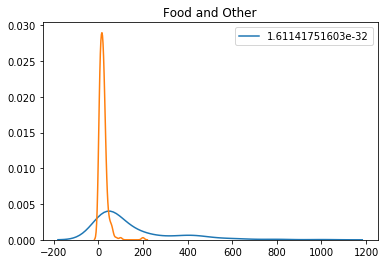

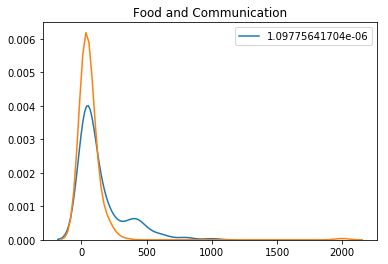

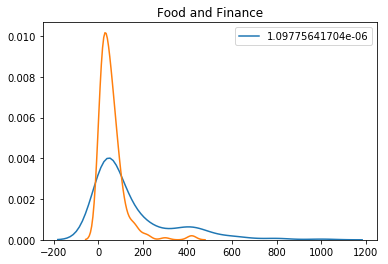

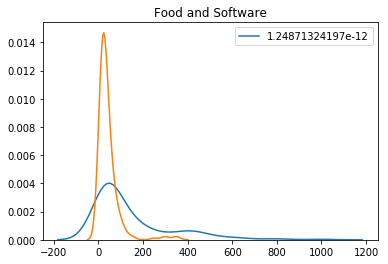

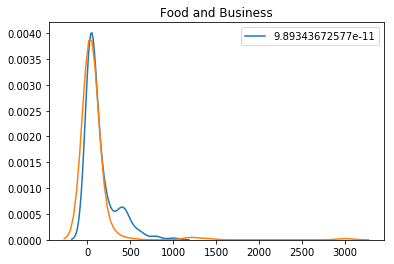

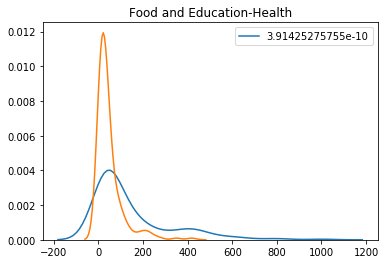

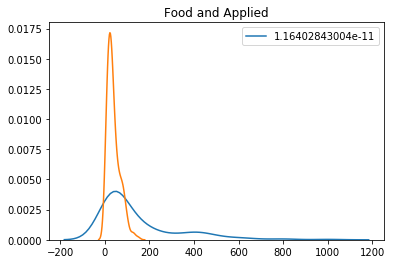

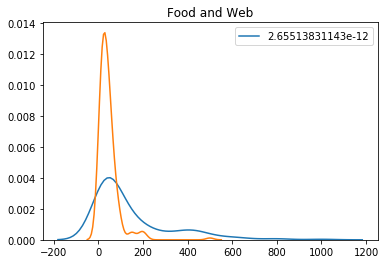

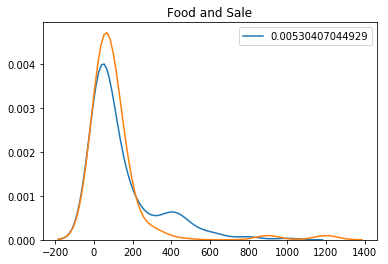

In [341]:
dists = [food_food_200, food_other_200, food_comm_200, food_fin_200, 
        food_soft_200, food_bus_200, food_eh_200, food_applied_200, 
        food_web_200, food_sale_200]
dists_name = ["Food", "Other", "Communication", "Finance", "Software", 
             "Business", "Education-Health", "Applied", "Web", "Sale"]
for a in range(1, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_food_200, ax = ax, hist = False, label = str(ks(food_food_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Food and " + dists_name[a])
    


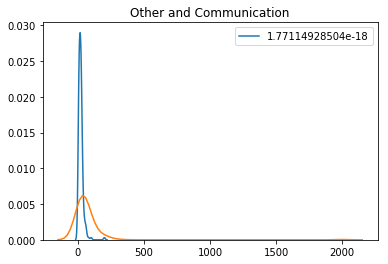

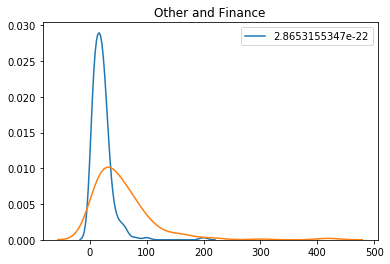

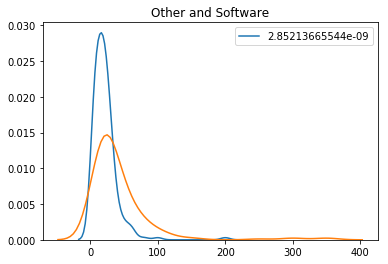

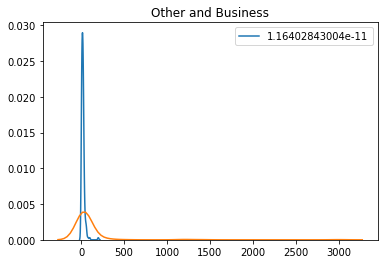

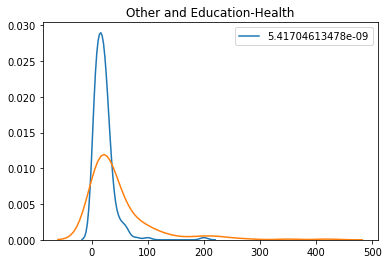

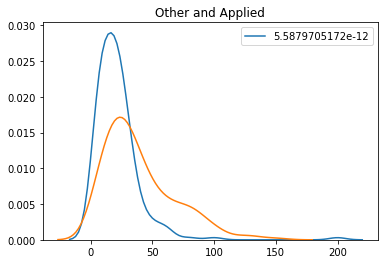

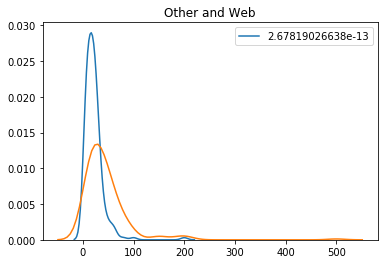

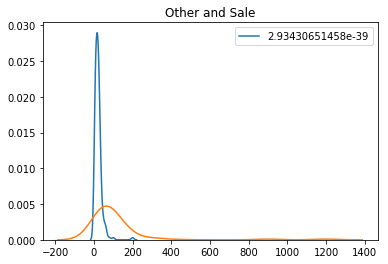

In [342]:
for a in range(2, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_other_200, ax = ax, hist = False, label = str(ks(food_other_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Other and " + dists_name[a])

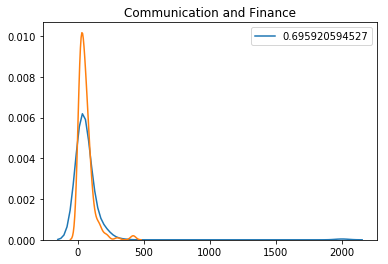

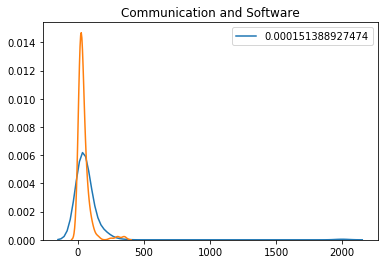

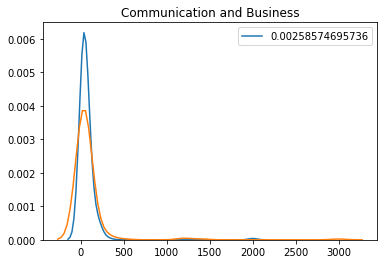

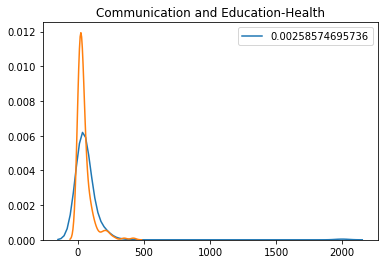

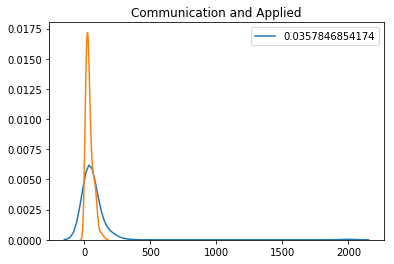

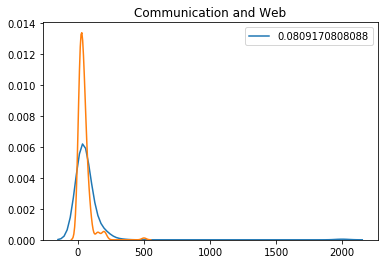

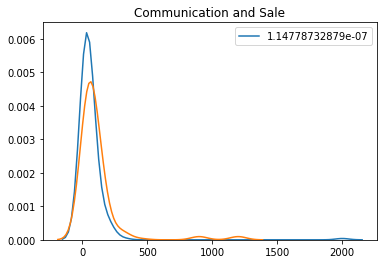

In [343]:
for a in range(3, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_comm_200, ax = ax, hist = False, label = str(ks(food_comm_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Communication and " + dists_name[a])

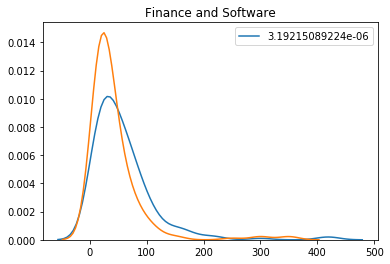

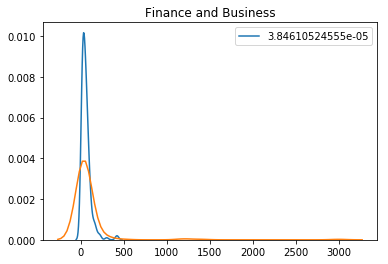

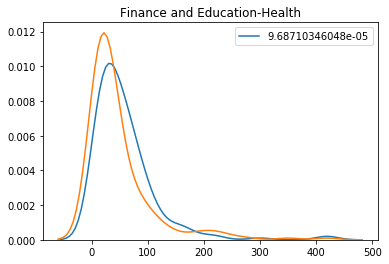

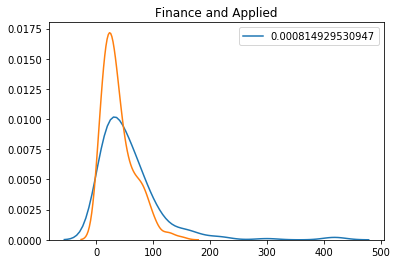

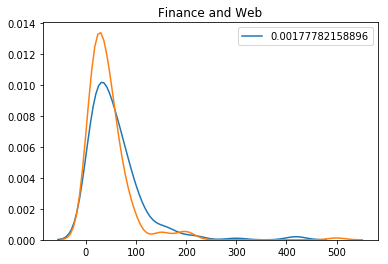

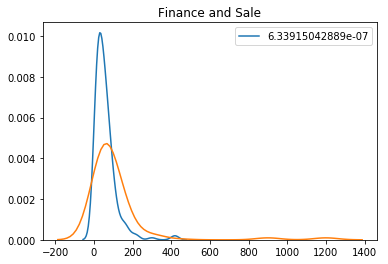

In [344]:
for a in range(4, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_fin_200, ax = ax, hist = False, label = str(ks(food_fin_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Finance and " + dists_name[a])

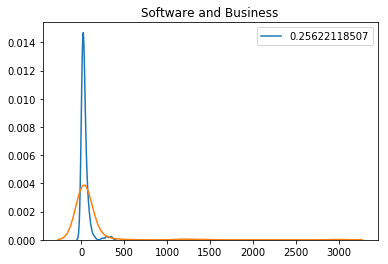

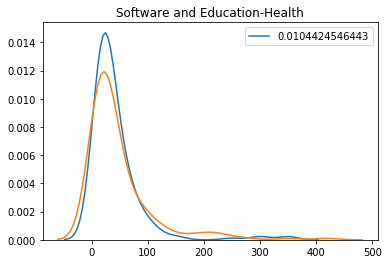

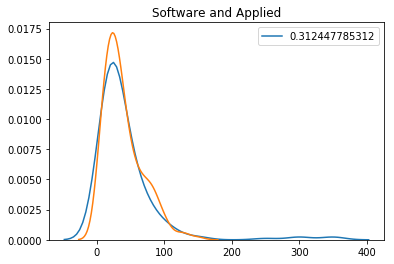

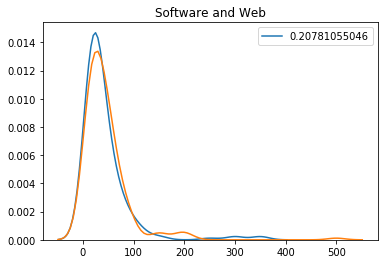

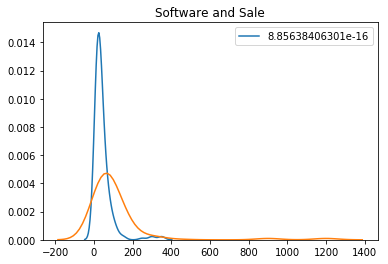

In [345]:
for a in range(5, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_soft_200, ax = ax, hist = False, label = str(ks(food_soft_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Software and " + dists_name[a])

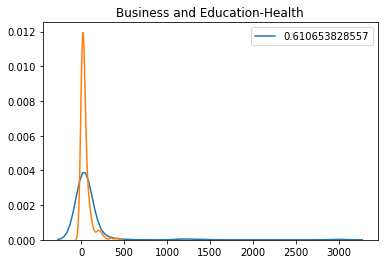

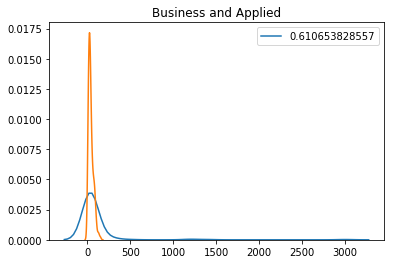

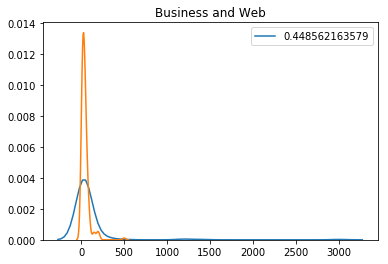

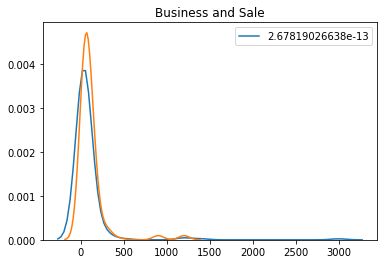

In [346]:
for a in range(6, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_bus_200, ax = ax, hist = False, label = str(ks(food_bus_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Business and " + dists_name[a])

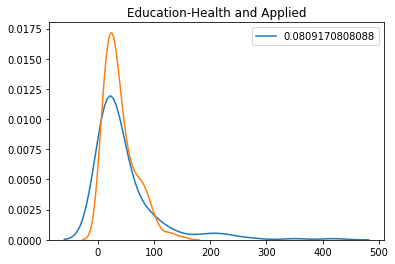

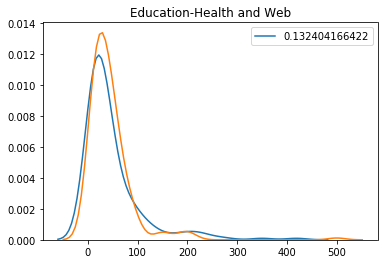

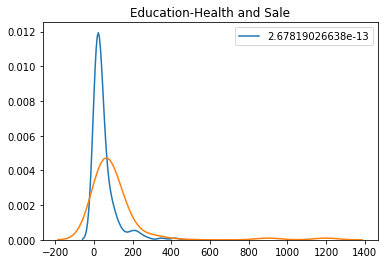

In [347]:
for a in range(7, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_eh_200, ax = ax, hist = False, label = str(ks(food_eh_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Education-Health and " + dists_name[a])

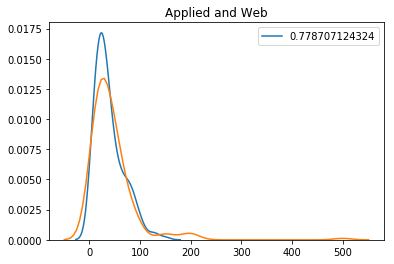

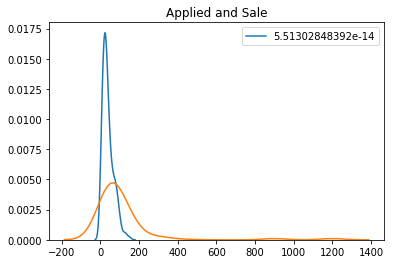

In [348]:
for a in range(8, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_applied_200, ax = ax, hist = False, label = str(ks(food_applied_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Applied and " + dists_name[a])

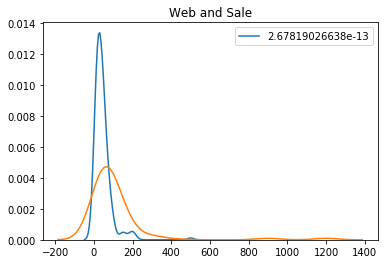

In [349]:
for a in range(9, 10):
    fig, ax = plt.subplots()
    sns.distplot(food_web_200, ax = ax, hist = False, label = str(ks(food_web_200, dists[a]).pvalue))
    sns.distplot(dists[a], ax = ax, hist = False)
    plt.title("Web and " + dists_name[a])

In [350]:
food["size"].value_counts()

200.0      1808
500.0      1376
1000.0      886
50.0        287
5000.0      214
10.0         90
10001.0      50
10000.0      42
Name: size, dtype: int64

In [351]:
food_200 = food[food["size"] == 200]["pounds"]
food_500 = food[food["size"] == 500]["pounds"]
food_1000 = food[food["size"] == 1000]["pounds"]
food_50 = food[food["size"] == 50]["pounds"]
food_5000 = food[food["size"] == 5000]["pounds"]
food_10 = food[food["size"] == 10]["pounds"]
food_10001 = food[food["size"] == 10001]["pounds"]
food_10000 = food[food["size"] == 10000]["pounds"]

In [353]:
random.seed(12385)
food_10_200 = np.random.choice(food_10, size = 200)
food_50_200 = np.random.choice(food_50, size = 200)
food_200_200 = np.random.choice(food_200, size = 200)
food_500_200 = np.random.choice(food_500, size = 200)
food_1000_200 = np.random.choice(food_1000, size = 200)
food_5000_200 = np.random.choice(food_5000, size = 200) 
food_10000_200 = np.random.choice(food_10000, size = 200) 
food_10001_200 = np.random.choice(food_10001, size = 200) 

In [354]:
size_dists = [food_10_200, food_50_200, food_200_200, food_500_200, 
        food_1000_200, food_5000_200, food_10000_200, food_10001_200]
dists_name = ["10", "50", "200", "500", "1000", "5000", "10000", "10001"]

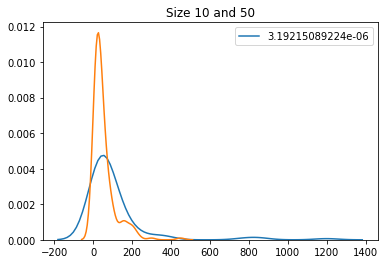

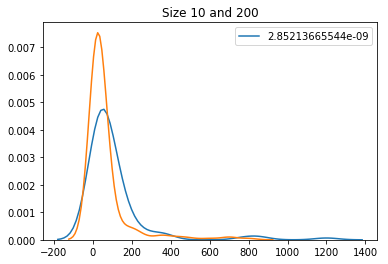

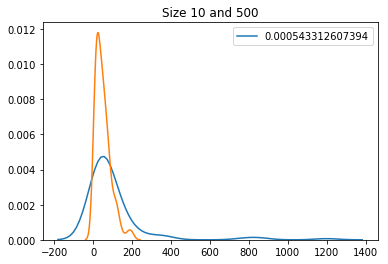

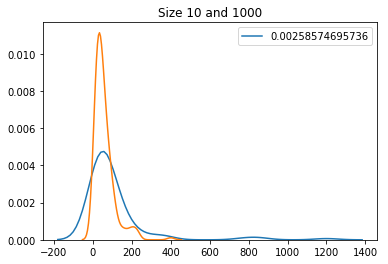

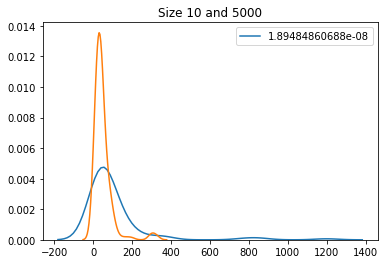

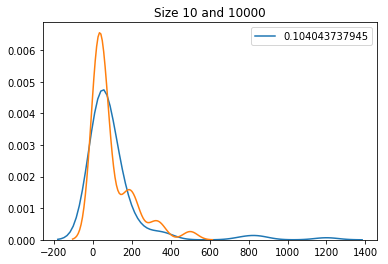

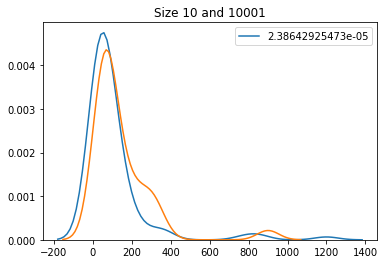

In [355]:
for a in range(1, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_10_200, ax = ax, hist = False, label = str(ks(food_10_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 10 and " + dists_name[a])
    

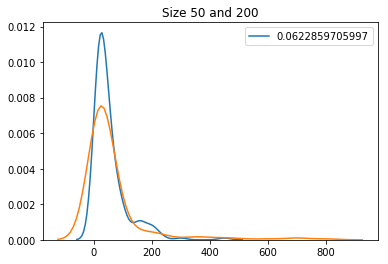

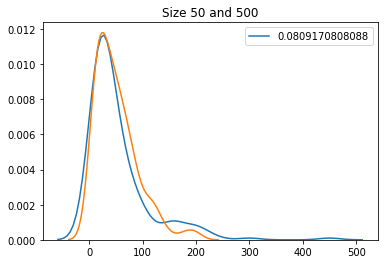

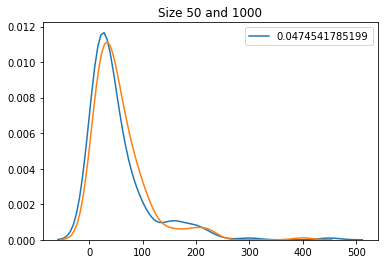

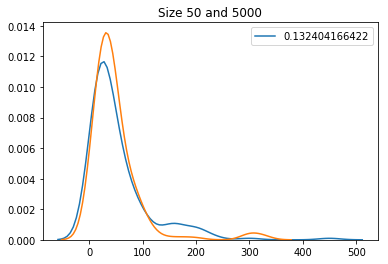

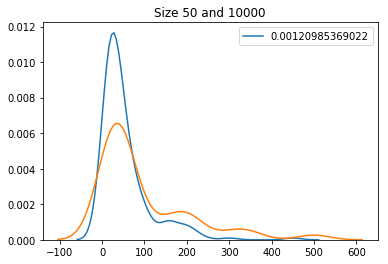

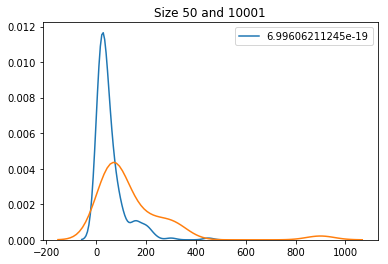

In [356]:
for a in range(2, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_50_200, ax = ax, hist = False, label = str(ks(food_50_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 50 and " + dists_name[a])
    

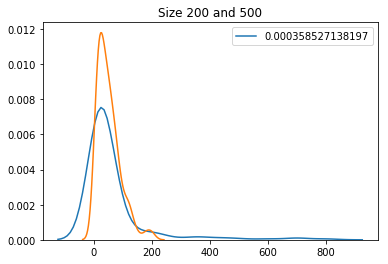

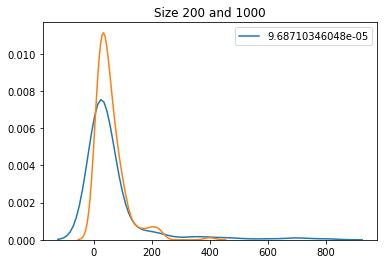

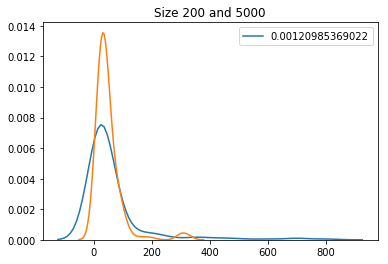

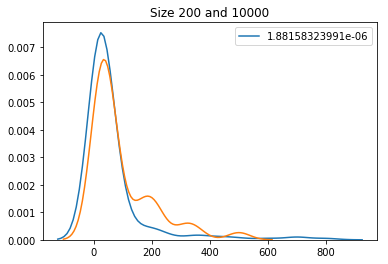

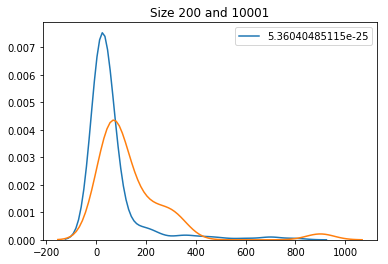

In [357]:
for a in range(3, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_200_200, ax = ax, hist = False, label = str(ks(food_200_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 200 and " + dists_name[a])
    

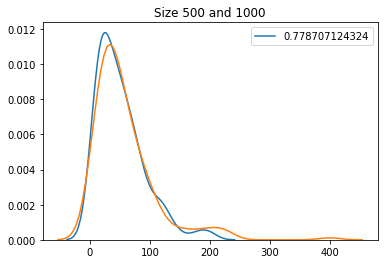

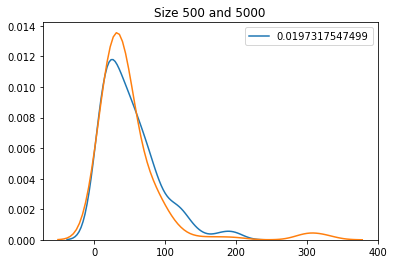

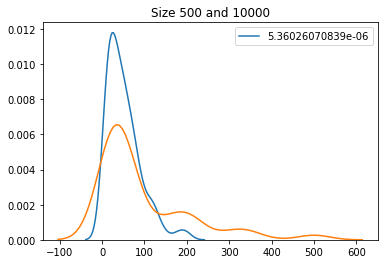

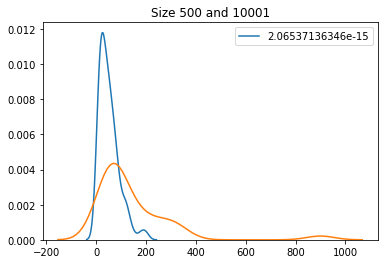

In [358]:
for a in range(4, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_500_200, ax = ax, hist = False, label = str(ks(food_500_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 500 and " + dists_name[a])
    

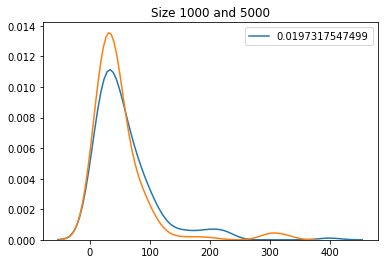

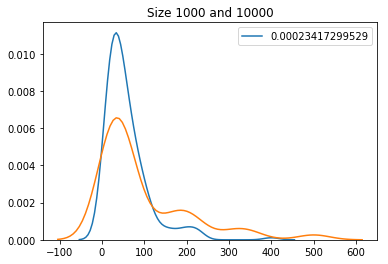

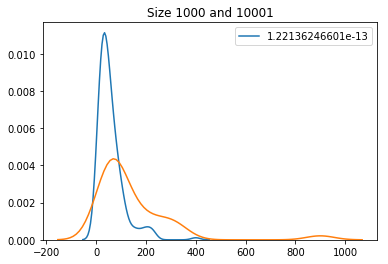

In [359]:
for a in range(5, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_1000_200, ax = ax, hist = False, label = str(ks(food_1000_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 1000 and " + dists_name[a])
    

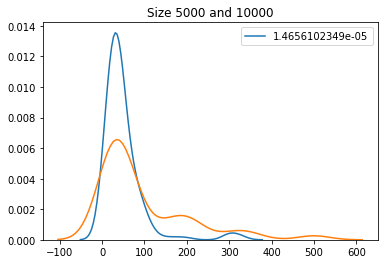

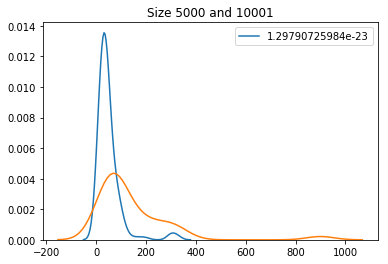

In [360]:
for a in range(6, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_5000_200, ax = ax, hist = False, label = str(ks(food_5000_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 5000 and " + dists_name[a])
    

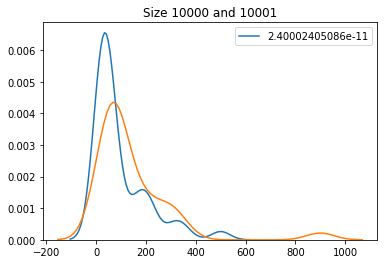

In [361]:
for a in range(7, 8):
    fig, ax = plt.subplots()
    sns.distplot(food_10000_200, ax = ax, hist = False, label = str(ks(food_10000_200, size_dists[a]).pvalue))
    sns.distplot(size_dists[a], ax = ax, hist = False)
    plt.title("Size 10000 and " + dists_name[a])
    